In [1]:
%matplotlib inline
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
# loop time
LOOP_TIME = 10000 / 1e6
LOOP_TIME

0.01

In [3]:
class Fin:
    def __init__(self, max_angle):
        self.max_angle = max_angle
        self.rotation_speed = 60 / 0.12 # to rotate 60 deg tates 0.12s -> degrees / sec
        self.current_angle = 0
        self.air_speed = 0
        self.area = 0.0018

    def update(self, target_angle, air_speed, dt):
        if abs(target_angle - self.current_angle) < self.rotation_speed * dt:
            self.current_angle = target_angle
        else:
            rotation_direction = (target_angle - self.current_angle) / abs(target_angle - self.current_angle)
            self.current_angle += rotation_direction * self.rotation_speed * dt
        
        if self.current_angle > self.max_angle:
            self.current_angle = self.max_angle
        elif self.current_angle < -self.max_angle:
            self.current_angle = -self.max_angle
        
        self.air_speed = air_speed

    def get_force(self):
        density_of_air = 1.293
        coef_of_lift = abs(math.sin(2.5 * math.pi/180 * self.current_angle))
        lift_force = 0.5 * coef_of_lift * density_of_air * self.area * (self.air_speed ** 2) * math.sin(math.pi/180 * self.current_angle)
        return lift_force

    def get_angle(self):
        return self.current_angle




class Drone:
    def __init__(self, max_pid_angle):
        self.mass = 0.5
        self.moment_of_inertia = 247.74*1e-6
        self.fin_distance = 0.1
        self.current_angle = 0
        self.angular_velocity = 0
        self.fins = [Fin(max_pid_angle)]
        self.pid_prev_error = 0
        self.pid_i = 0
        self.max_pid_angle = max_pid_angle

    def update(self, k_pid, target_angle, air_speed, dt):
        total_force = np.array([f.get_force() for f in self.fins]).sum()

        # calculate the angular velocity and angle
        torque = total_force * self.fin_distance
        angular_acceleration = torque / self.moment_of_inertia
        self.angular_velocity += angular_acceleration * dt
        self.current_angle += self.angular_velocity
        
        pid = self.calculate_pid(k_pid, target_angle)

        for f in self.fins:
            f.update(pid, air_speed, dt)


    def calculate_pid(self, k_pid, target_angle):
        kp, ki, kd = k_pid
        error = target_angle - self.current_angle
        pid_p = kp * error
        delta_error = error - self.pid_prev_error
        if abs(delta_error) < 10:
            self.pid_i += ki * error
        else:
            self.pid_i = 0
        pid_d = kd * delta_error
        pid = pid_p + self.pid_i + pid_d
        self.pid_prev_error = error

        return pid

    def get_data(self):
        return self.current_angle, self.fins[0].get_angle(), self.fins[0].get_force()

            

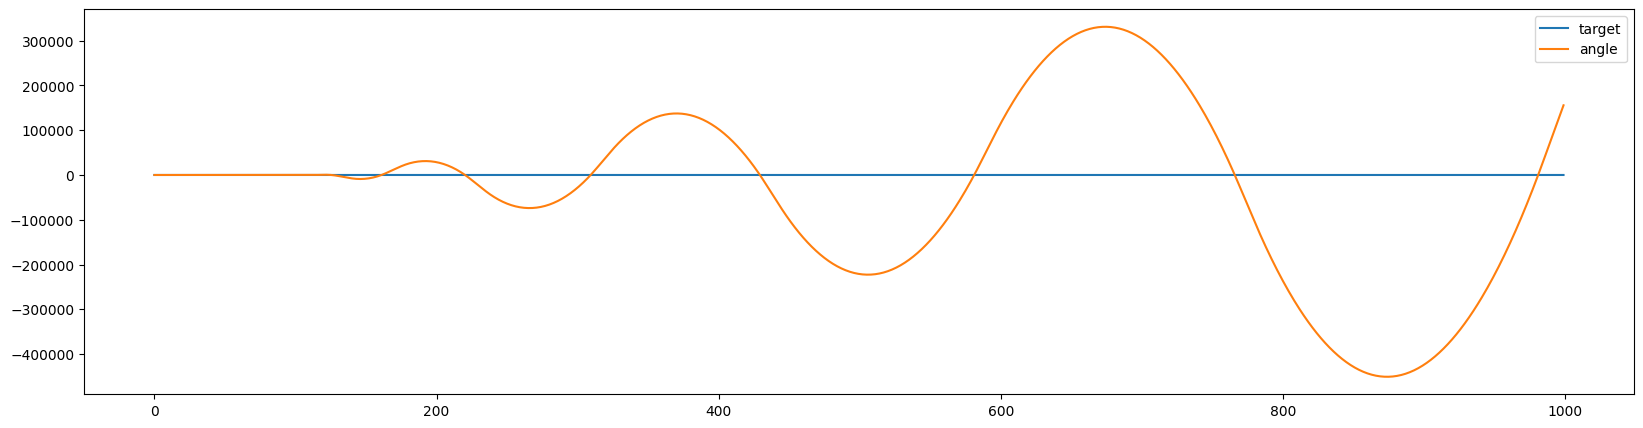

In [8]:
dron = Drone(45)
targets = [0, 10]
data = []

kp = 1
ki = 0.00
kd = 0

for i in range(1000):
    if i%100 == 0:
        idx = i // 100
        if idx >= len(targets):
            idx = len(targets) - 1
        target = targets[idx]
    dron.update((kp, ki, kd), target, 160, LOOP_TIME)
    angle, fin_angle, fin_force = dron.get_data()
    data.append([target, angle, fin_angle, fin_force])

data = np.array(data)

_data = data#[480:550]
plot_data = [
    [_data[:, 0], 'target'],
    [_data[:, 1], 'angle'],
    # [_data[:, 2], 'fin angle'],
    # [_data[:, 3], 'force'],
]
plt.figure(figsize=(20, 5))
for d, _ in plot_data:
    plt.plot(d)
plt.legend([p[1] for p in plot_data])
plt.show()

In [5]:
np.array([2,5]).sum()

7